In [93]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, silhouette_samples, silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import sklearn
import statsmodels
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import copy
import requests
import pprint
import xgboost
import scipy
import warnings
import re
from datetime import datetime
from scipy import stats
from xgboost import XGBClassifier
from urllib import parse
from bs4 import BeautifulSoup

# 지수 형태의 실수를 소수점 3자리까지 표기
pd.options.display.float_format = "{:.3f}".format

# 공유 폴더 경로
dirShare = ".."

# 경고 출력 무시
warnings.filterwarnings("ignore")

In [94]:
# 라이브러리 버전 확인
print("pandas 현재 버전 : " + pd.__version__)
print("scikit-learn 현재 버전 : " + sklearn.__version__)
print("scipy 현재 버전 : "+ scipy.__version__)
print("statsmodels 현재 버전 : " + statsmodels.__version__)
print("xgboost 현재 버전 : " + xgboost.__version__)

pandas 현재 버전 : 2.0.3
scikit-learn 현재 버전 : 1.3.0
scipy 현재 버전 : 1.11.1
statsmodels 현재 버전 : 0.14.0
xgboost 현재 버전 : 1.7.6


# 데이터 불러오고 전처리

## 기본전처리

In [95]:
# train.csv 데이터 프레임으로 불러오기
df = pd.read_csv(dirShare+"/data/train.csv")

# df 정보 확인
df.info()

# df 상위 10개 불러오기
# df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 58 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   inst_id             301 non-null    int64  
 1   OC                  301 non-null    object 
 2   sido                301 non-null    object 
 3   sgg                 301 non-null    int64  
 4   openDate            301 non-null    int64  
 5   bedCount            296 non-null    float64
 6   instkind            300 non-null    object 
 7   revenue1            293 non-null    float64
 8   salescost1          293 non-null    float64
 9   sga1                293 non-null    float64
 10  salary1             293 non-null    float64
 11  noi1                293 non-null    float64
 12  noe1                293 non-null    float64
 13  interest1           293 non-null    float64
 14  ctax1               293 non-null    float64
 15  profit1             293 non-null    float64
 16  liquidAs

In [96]:
df_t = pd.read_csv(dirShare+"/data/test.csv")

df_t.info()
df_t.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 58 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   inst_id             127 non-null    int64  
 1   OC                  0 non-null      float64
 2   sido                127 non-null    object 
 3   sgg                 127 non-null    int64  
 4   openDate            126 non-null    float64
 5   bedCount            119 non-null    float64
 6   instkind            125 non-null    object 
 7   revenue1            125 non-null    float64
 8   salescost1          125 non-null    float64
 9   sga1                125 non-null    float64
 10  salary1             125 non-null    float64
 11  noi1                125 non-null    float64
 12  noe1                125 non-null    float64
 13  interest1           125 non-null    float64
 14  ctax1               125 non-null    float64
 15  profit1             125 non-null    float64
 16  liquidAs

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,2,NaN,incheon,139,19981125.000,300.000,general_hospital,66824864410.000,0.000,65657092101.000,...,55406431667.000,50684431667.000,37143344381.000,4720000000.000,4690000000.000,16085395374.000,8944587276.000,693,693,same
1,5,NaN,jeju,149,20160309.000,44.000,hospital,34957575568.000,0.000,32592697196.000,...,67308375170.000,42098280733.000,24200000000.000,25210094437.000,18300000000.000,3789134965.000,0.000,379,371,same
2,6,NaN,jeonnam,103,19890427.000,276.000,general_hospital,23260305967.000,2542570943.000,23087485220.000,...,0.000,27775892339.000,21822782890.000,0.000,0.000,0.000,16385400958.000,NaN,NaN,NaN
3,8,NaN,busan,71,20100226.000,363.000,general_hospital,0.000,0.000,0.000,...,12115167523.000,9556237015.000,4251867179.000,2558930508.000,0.000,39142835592.000,0.000,760,760,same
4,10,NaN,jeonbuk,26,20040604.000,213.000,general_hospital,50370249897.000,0.000,48558027276.000,...,43959732611.000,7535567468.000,3298427375.000,36424165143.000,21347120000.000,25744878066.000,15072685841.000,437,385,same


In [97]:
# 데이터 개수 확인하기
print("train 데이터 개수 : ", df.shape[0])
print("test 데이터 개수 : ", df_t.shape[0])

# len(df)를 써도 동일

train 데이터 개수 :  301
test 데이터 개수 :  127


In [98]:
# 숫자 형식의 컬럼의 기술통계값을 출력, train.csv
df.describe()

,inst_id,sgg,openDate,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,...,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2
count,301.000,301.000,301.000,296.000,293.000,293.000,293.000,293.000,293.000,293.000,...,293.000,293.000,293.000,293.000,293.000,293.000,293.000,293.000,291.000,288.000
mean,219.056,81.040,20050125.801,145.709,12881747447.993,2014902794.594,10332439064.089,5654114566.904,269615124.573,511587022.570,...,222670.000,8146026488.788,3860583593.406,1510050431.986,4471247363.877,2709978815.423,5273919018.089,978627865.256,142.546,134.326
std,121.235,50.970,88938.154,118.924,20435433475.616,7460270656.568,14938862491.946,8083342530.256,802370115.514,1060379255.452,...,3811496.447,12557995349.365,6797242094.076,2953412250.368,7659580436.397,4564001070.999,10812593821.248,4688797890.975,160.191,151.062
min,1.000,1.000,19780124.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,-20147802018.000,-2781506722.000,0.000,0.000
25%,112.000,37.000,20011017.000,52.750,3252111902.000,0.000,2758200772.000,1626052720.000,8217133.000,80133952.000,...,0.000,1283220350.000,285574118.000,0.000,25578782.000,0.000,1017572570.000,0.000,53.500,53.750
50%,230.000,75.000,20071126.000,136.500,5524218104.000,210410492.000,4684074465.000,2659892367.000,43637641.000,183196506.000,...,0.000,3784552900.000,1454049945.000,85425488.000,1969746813.000,1100000000.000,2894969804.000,0.000,80.000,79.000
75%,321.000,123.000,20111021.000,193.000,12748392940.000,910527771.000,10778762060.000,6363400069.000,205033071.000,420333030.000,...,0.000,8465053127.000,4364713622.000,1567966980.000,4905441439.000,3360000000.000,5370284792.000,101444685.000,181.500,170.000
max,428.000,178.000,20170607.000,656.000,151000000000.000,98503322990.000,103000000000.000,64035593950.000,9144170639.000,8686379500.000,...,65242310.000,85088583901.000,68468775764.000,17593752360.000,51503883627.000,32561472110.000,125000000000.000,68527297093.000,1200.000,1200.000


In [99]:
# 숫자 형식의 컬럼의 기술통계값을 출력, test.csv
df_t.describe()

,inst_id,OC,sgg,openDate,bedCount,revenue1,salescost1,sga1,salary1,noi1,...,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2
count,127.000,0.000,127.000,126.000,119.000,125.000,125.000,125.000,125.000,125.000,...,125.000,125.000,125.000,125.000,125.000,125.000,125.000,125.000,125.000,125.000
mean,205.906,NaN,95.858,20050851.333,172.790,18244463620.632,3973320516.568,13404099537.944,7415083961.448,517551263.832,...,13362088426.024,351383068.584,19731.144,11898512213.344,5633432084.136,2181713388.144,6495025895.904,4482682424.408,6116178748.752,1648473877.648
std,131.802,NaN,52.684,87958.149,126.024,31335295156.854,14199483023.803,20544811391.822,12100434017.387,1193138608.474,...,20854039250.721,979109688.084,220600.896,19711820111.028,9662047510.141,4952448637.736,12036733189.767,7517020054.736,9813461143.417,4779443752.861
min,2.000,NaN,6.000,19760409.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-2955957091.000,-8600000000.000
25%,89.000,NaN,51.000,20000826.000,94.000,3235888530.000,0.000,3083860292.000,1666742310.000,16410940.000,...,2807762809.000,0.000,0.000,1679896491.000,391415567.000,0.000,132136760.000,0.000,949265633.000,0.000
50%,199.000,NaN,95.000,20071066.000,156.000,6637115540.000,189692304.000,5716501623.000,3263054070.000,53191709.000,...,5450482767.000,33173766.000,0.000,4494217146.000,1554505639.000,300000000.000,2030000000.000,1750000000.000,2427138957.000,0.000
75%,328.000,NaN,144.500,20117895.500,213.000,17040391156.000,1192329214.000,14452425786.000,7198103374.000,371459225.000,...,11871143997.000,204899800.000,0.000,14120305387.000,6586241453.000,2650000000.000,5700000000.000,4857047850.000,5881964991.000,693516549.000
max,431.000,NaN,177.000,20170531.000,771.000,181000000000.000,116000000000.000,127000000000.000,82395611833.000,7302719335.000,...,113000000000.000,7112779552.000,2466393.000,131000000000.000,52414267533.000,37143344381.000,78556538604.000,36202877976.000,49244922328.000,25617866194.000


In [100]:
# 컬럼별 null 값 확인하기, train.csv
df.shape[0] - df.count()

inst_id                0
OC                     0
sido                   0
sgg                    0
openDate               0
bedCount               5
instkind               1
revenue1               8
salescost1             8
sga1                   8
salary1                8
noi1                   8
noe1                   8
interest1              8
ctax1                  8
profit1                8
liquidAsset1           8
quickAsset1            8
receivableS1           8
inventoryAsset1        8
nonCAsset1             8
tanAsset1              8
OnonCAsset1            8
receivableL1           8
debt1                  8
liquidLiabilities1     8
shortLoan1             8
NCLiabilities1         8
longLoan1              8
netAsset1              8
surplus1               8
revenue2               8
salescost2             8
sga2                   8
salary2                8
noi2                   8
noe2                   8
interest2              8
ctax2                  8
profit2                8


In [101]:
# 컬럼별 null 값 확인하기, test.csv
df_t.shape[0] - df_t.count()

inst_id                 0
OC                    127
sido                    0
sgg                     0
openDate                1
bedCount                8
instkind                2
revenue1                2
salescost1              2
sga1                    2
salary1                 2
noi1                    2
noe1                    2
interest1               2
ctax1                   2
profit1                 2
liquidAsset1            2
quickAsset1             2
receivableS1            2
inventoryAsset1         2
nonCAsset1              2
tanAsset1               2
OnonCAsset1             2
receivableL1            2
debt1                   2
liquidLiabilities1      2
shortLoan1              2
NCLiabilities1          2
longLoan1               2
netAsset1               2
surplus1                2
revenue2                2
salescost2              2
sga2                    2
salary2                 2
noi2                    2
noe2                    2
interest2               2
ctax2       

In [102]:
# employee 컬럼이 object 타입이고, 숫자에 ','이 포함돼 있어 정규 표현식으로 없앰
for i in range(2) : 
    df_t["employee"+str(i+1)] = df_t["employee"+str(i+1)].map(lambda x: re.sub(r"[^0-9.-]", "", str(x)))

df_t[["employee1", "employee2"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   employee1  127 non-null    object
 1   employee2  127 non-null    object
dtypes: object(2)
memory usage: 2.1+ KB


In [103]:
# 실수 타입으로 변경
df_t["employee1"].replace("", np.NaN, inplace=True)
df_t["employee2"].replace("", np.NaN, inplace=True)
df_t[["employee1", "employee2"]] = df_t[["employee1", "employee2"]].astype("float64")
df_t[["employee1", "employee2"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   employee1  119 non-null    float64
 1   employee2  112 non-null    float64
dtypes: float64(2)
memory usage: 2.1 KB


In [104]:
df_t[["employee1", "employee2"]].head()

,employee1,employee2
0,693.000,693.000
1,379.000,371.000
2,NaN,NaN
3,760.000,760.000
4,437.000,385.000


In [105]:
# train과 test를 일시적으로 합침
df = pd.concat(objs=[df,df_t], axis=0)
print("합친 데이터 수 : ",len(df))

합친 데이터 수 :  428


In [106]:
# 아직 운영 중인 병원을 1로 변환
df.replace({"open":1},inplace=True)
# 폐업한 병원을 0으로 변환
df.replace({" close":0}, inplace=True)
# unique() 메서드를 통해 "OC" 컬럼의 데이터를 확인
# df["OC"].unique()

In [107]:
# 오너 변환 여부
df["ownerChange"].replace({"same":0},inplace=True)
df["ownerChange"].replace({"change":1},inplace=True)
# df["ownerChange"].unique()

In [108]:
df["instkind"].unique()

array(['nursing_hospital', 'general_hospital', 'hospital',
       'traditional_clinic', 'clinic', 'traditional_hospital',
       'dental_clinic', nan], dtype=object)

![EVA논문 일부1](../data/EVA논문1_1.png)  
![EVA논문 일부2](../data/EVA논문1_2.png)  

이익잉여금은 기업의 경상적인 영업활동, 고정자산의 처분, 그 밖의 자산의 처분 및 기타 임시적인 손익거래에서 생긴 결과로서 주주에게 배당금으로 지급하거나 자본으로 대체되지 않고 남아있는 부분을 말한다. 이익잉여금은 기업의 경영활동에 의한 손익거래에 의하여 발생하는 이익을 원천으로 하는 잉여금을 의미한다. 이익잉여금은 이익준비금, 기타 법정적립금, 임의적립금, 당기말 미처분이익잉여금 또는 당기말 미처리결손금의 4가지로 크게 구분된다. 총자산에서 부채와 자본금을 공제한 잔액을 잉여금이라 하는데, 이익잉여금은 이익적립금ㆍ임의적립금(자산재평가적립금 제외) 또는 당기말 미처분이익잉여금과 같이 영업거래에서 발생하는 이익의 유보를 말하는 것으로 자본거래에서 나타나는(주식의 발행차금ㆍ감자차익ㆍ합병차익) 자본잉여금과는 다르다.  
출처 : https://txsi.hometax.go.kr/docs/customer/dictionary/view.jsp?word=&word_id=7243  

자기자본(Owners' Equity, Owner's Capital)
기업의 총자본에서 차입자본금(부채)를 뺀 금액으로, 미래 일정 시점에 상환해야 할 의무가 없는 기업 고유의 재산이다. 소유주에게 귀속되어야 할 몫을 나타내기 때문에 소유주지분 또는 주주지분이라고도 불린다. 회사의 설립 때 납입된 자본과 영업활동을 하면서 벌어들인 이익 등으로 구성된다. 자기자본은 구체적 구성항목은 자본금ㆍ자본잉여금ㆍ주식발행초과금ㆍ기타포괄손익누계액ㆍ이익잉여금이며, 여기서의 자본금은 주주들이 현금이나 기타자산으로 직접 투자한 자본 중 주식의 액면가액에 해당되는 금액을 의미하며 납입자본(contributed capital)이라 불리기도 한다.  
출처 : https://www.moef.go.kr/sisa/dictionary/detail?idx=2098  

EVA는 기업의 고유한 영업호라동을 통해 창출된 순가치의 증가분으로, 세후 영업이익에서 투하 자본에 대한 자본 비용이 공제된 잔여이익
EVA = 세후순영업이익 - 자본비용  
    = (영업관련 경상이익-법인세) - (타인자본비용+자기자본비용)

In [109]:
# 영업이익 컬럼 추가(매출액 - 매출원가 - 판매 관리비 - 급여)
# revenue - salescost - sga - salary

for i in range(2) : 
    df.insert(loc=(24*(i)+11), column="busiProfit"+str(i+1), value=(df["revenue"+str(i+1)]-df["salescost"+str(i+1)]-df["sga"+str(i+1)]-df["salary"+str(i+1)]))

In [110]:
# 병원 종류 별 병상 수의 차이
df_bed = df.groupby("instkind",axis=0)["bedCount"].count()
df_bed

instkind
clinic                   22
dental_clinic             1
general_hospital         56
hospital                120
nursing_hospital        204
traditional_clinic        5
traditional_hospital      6
Name: bedCount, dtype: int64

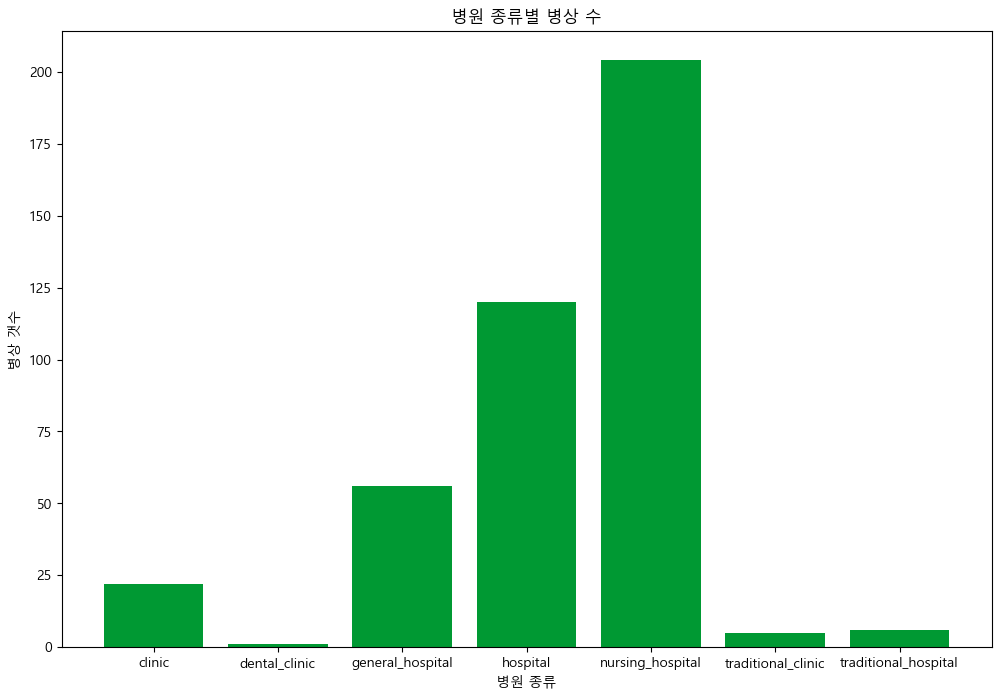

In [111]:
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(12,8))
    
plt.bar(x=df_bed.index, height=df_bed, color="#009933")
plt.title("병원 종류별 병상 수")
plt.xlabel("병원 종류")
plt.ylabel("병상 갯수")
plt.show()

In [112]:
# 개업한 날짜는 변수로서 의미가 없음. 모델은 날짜를 인식하지 못하기 때문에
# 개업 날짜와 폐업 날짜의 차이로 변수를 조정할 필요가 있음

date_of_2018 = "2018-01-01"

# 문자 타입을 date 타입으로

# df["openDate"] = df["openDate"].apply(lambda x : datetime.strptime(str(x), "%Y%m%d")) # ValueError: unconverted data remains: .0
df["openDate"] = pd.to_datetime(df["openDate"], format="%Y%m%d")

# 날짜 차이를 새로운 컬럼으로 생성, 데이터 프레임 중간에 삽입
df.insert(2, "dif_date", datetime.strptime(date_of_2018,"%Y-%m-%d")-df["openDate"])
df["dif_date"] = df["dif_date"].dt.days

df.drop(labels="openDate", axis=1, inplace=True)

df["dif_date"].tail()

122   5925.000
123   6060.000
124   6209.000
125   6178.000
126   7686.000
Name: dif_date, dtype: float64

In [113]:
df_clst = df[["inst_id","OC", "dif_date","bedCount","busiProfit1", "busiProfit2", "profit1", "surplus1", "profit2", "surplus2", 
                  "employee1", "employee2", "instkind", "sido"]]

df_clst.info()

<class 'pandas.core.frame.DataFrame'>
Index: 428 entries, 0 to 126
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   inst_id      428 non-null    int64  
 1   OC           301 non-null    float64
 2   dif_date     427 non-null    float64
 3   bedCount     415 non-null    float64
 4   busiProfit1  418 non-null    float64
 5   busiProfit2  418 non-null    float64
 6   profit1      418 non-null    float64
 7   surplus1     418 non-null    float64
 8   profit2      418 non-null    float64
 9   surplus2     418 non-null    float64
 10  employee1    410 non-null    float64
 11  employee2    400 non-null    float64
 12  instkind     425 non-null    object 
 13  sido         428 non-null    object 
dtypes: float64(11), int64(1), object(2)
memory usage: 50.2+ KB


In [114]:
# 병원의 종류를, get_dummies를 이용해 one-hot-encoding
df = pd.get_dummies(df, columns=["instkind"], prefix=["instkind"], prefix_sep="_", dtype=int)
df_clst = pd.get_dummies(df_clst, columns=["instkind"], prefix=["instkind"], prefix_sep="_", dtype=int)

In [115]:
# 영어로 돼 있는 '시도'를 한글로 변환

df["sido"].replace(['choongnam', 'gyeongnam', 'gyeonggi', 'incheon', 'busan',
       'jeonnam', 'seoul', 'jeonbuk', 'choongbuk', 'ulsan', 'daejeon',
       'daegu', 'gyeongbuk', 'gangwon', 'gwangju', 'sejong'], 
       ["충청남도", "경상남도", "경기도", "인천광역시", '부산광역시', '전라남도', '서울특별시', 
        '전라북도', '충청북도', '울산광역시', '대전광역시', '대구광역시', "경상북도", "강원도", "광주광역시", "세종특별자치시"],inplace=True)

df_clst["sido"].replace(['choongnam', 'gyeongnam', 'gyeonggi', 'incheon', 'busan',
       'jeonnam', 'seoul', 'jeonbuk', 'choongbuk', 'ulsan', 'daejeon',
       'daegu', 'gyeongbuk', 'gangwon', 'gwangju', 'sejong'], 
       ["충청남도", "경상남도", "경기도", "인천광역시", '부산광역시', '전라남도', '서울특별시', 
        '전라북도', '충청북도', '울산광역시', '대전광역시', '대구광역시', "경상북도", "강원도", "광주광역시", "세종특별자치시"],inplace=True)

print("df의 시도 : ",df["sido"].unique())
print("df_clst의 시도 : ",df_clst["sido"].unique())

df의 시도 :  ['충청남도' '경상남도' '경기도' '인천광역시' '부산광역시' '전라남도' '서울특별시' '전라북도' '충청북도' '울산광역시'
 '대전광역시' '대구광역시' '경상북도' '강원도' '광주광역시' '세종특별자치시' 'jeju']
df_clst의 시도 :  ['충청남도' '경상남도' '경기도' '인천광역시' '부산광역시' '전라남도' '서울특별시' '전라북도' '충청북도' '울산광역시'
 '대전광역시' '대구광역시' '경상북도' '강원도' '광주광역시' '세종특별자치시' 'jeju']


## 심화전처리

In [116]:
# 2017년 지역별 인구수 데이터
# https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1B040A3
pop = pd.read_csv(dirShare+"/data/행정구역_시군구_별__성별_인구수_20230718231833.csv", header=1, encoding="cp949")
pop.info()
pop.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   행정구역(시군구)별  18 non-null     object
 1   총인구수 (명)    18 non-null     int64 
 2   남자인구수 (명)   18 non-null     int64 
 3   여자인구수 (명)   18 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 708.0+ bytes


,행정구역(시군구)별,총인구수 (명),남자인구수 (명),여자인구수 (명)
0,전국,51778544,25855919,25922625
1,서울특별시,9857426,4830206,5027220
2,부산광역시,3470653,1709508,1761145
3,대구광역시,2475231,1227814,1247417
4,인천광역시,2948542,1479597,1468945


In [117]:
# df와 pop(인구수) join
df_new = pd.merge(df, pop, how="inner", left_on="sido", right_on="행정구역(시군구)별")
df_clst = pd.merge(df_clst, pop, how="inner", left_on="sido", right_on="행정구역(시군구)별")
print(df_new.head())
print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-")
print(df_clst.head())

   inst_id    OC  dif_date  sido  sgg  bedCount        revenue1  \
0        1 1.000  3657.000  충청남도   73   175.000  4217530010.000   
1       59 1.000  1385.000  충청남도   94   258.000  8546126935.000   
2      101 1.000 13026.000  충청남도   37   341.000 52626386641.000   
3      134 1.000 10804.000  충청남도   78    64.000  4402779495.000   
4      150 1.000  1589.000  충청남도   94   186.000  5237992090.000   

       salescost1            sga1         salary1  ...  \
0           0.000  3961134739.000  2033835290.000  ...   
1           0.000  6737509250.000  3830658980.000  ...   
2 19326736791.000 32214235859.000 20975361934.000  ...   
3   719458530.000  4131517858.000  2436024468.000  ...   
4           0.000  5060655115.000  2623322811.000  ...   

   instkind_dental_clinic  instkind_general_hospital  instkind_hospital  \
0                       0                          0                  0   
1                       0                          0                  0   
2                      

In [118]:
# 시도를 one-hot-encoding
df_new = pd.get_dummies(df_new, columns=["sido"], prefix=["sido"], prefix_sep="_", dtype=int)
df_clst = pd.get_dummies(df_clst, columns=["sido"], prefix=["sido"], prefix_sep="_", dtype=int)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   inst_id                        425 non-null    int64  
 1   OC                             301 non-null    float64
 2   dif_date                       424 non-null    float64
 3   sgg                            425 non-null    int64  
 4   bedCount                       413 non-null    float64
 5   revenue1                       415 non-null    float64
 6   salescost1                     415 non-null    float64
 7   sga1                           415 non-null    float64
 8   salary1                        415 non-null    float64
 9   busiProfit1                    415 non-null    float64
 10  noi1                           415 non-null    float64
 11  noe1                           415 non-null    float64
 12  interest1                      415 non-null    flo

In [119]:
# 병원 군집을 통해 결측치 예측을 하고자 함, surplus1 / 2, profit1 / 2, employee 1 / 2
df_new.drop(columns="행정구역(시군구)별", axis=1, inplace=True)
df_clst.drop(columns="행정구역(시군구)별", axis=1, inplace=True)

df_clst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   inst_id                        425 non-null    int64  
 1   OC                             301 non-null    float64
 2   dif_date                       424 non-null    float64
 3   bedCount                       413 non-null    float64
 4   busiProfit1                    415 non-null    float64
 5   busiProfit2                    415 non-null    float64
 6   profit1                        415 non-null    float64
 7   surplus1                       415 non-null    float64
 8   profit2                        415 non-null    float64
 9   surplus2                       415 non-null    float64
 10  employee1                      407 non-null    float64
 11  employee2                      397 non-null    float64
 12  instkind_clinic                425 non-null    int

In [120]:
# NaN 값이 없는 컬럼만 남기고, 지역 데이터 없애기
df_kmeans = df_clst.dropna(axis=1, how="any")
df_kmeans = df_kmeans.iloc[:, :11]
df_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   inst_id                        425 non-null    int64
 1   instkind_clinic                425 non-null    int32
 2   instkind_dental_clinic         425 non-null    int32
 3   instkind_general_hospital      425 non-null    int32
 4   instkind_hospital              425 non-null    int32
 5   instkind_nursing_hospital      425 non-null    int32
 6   instkind_traditional_clinic    425 non-null    int32
 7   instkind_traditional_hospital  425 non-null    int32
 8   총인구수 (명)                       425 non-null    int64
 9   남자인구수 (명)                      425 non-null    int64
 10  여자인구수 (명)                      425 non-null    int64
dtypes: int32(7), int64(4)
memory usage: 25.0 KB


## kmeans를 통한 병원 세그먼트 군집

In [ ]:
def visualize_silhouette(cluster_lists, X_features): 

    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [ ]:
scaler1 = MinMaxScaler()

df_mmsc = df_kmeans.drop(columns=["inst_id"])

scalerX1 = scaler1.fit(df_mmsc)

X_mmsc1 = scaler1.transform(df_mmsc)

In [ ]:
visualize_silhouette([2,3,4,5,7,9,10,12,15], X_mmsc1)
# 12개가 됐을 때 실루엣 계수가 0.889으로 최대

In [ ]:
clst_kmeans = KMeans(n_clusters=12, random_state=0, max_iter=500)

model = clst_kmeans.fit(X_mmsc1)
clst_label = model.labels_

print(clst_label)

In [ ]:
df_kmeans["NumberOfCluster"] = pd.Series(clst_label)
df_kmeans.tail()

In [ ]:
# df_kmeans.head()

In [ ]:
df_kmeans.groupby(by="NumberOfCluster", axis=0)["inst_id"].count()

In [ ]:
# 재무 정보가 포함돼 있는 데이터 프레임에 클러스터링 넘버 삽입
df_join_clst = pd.merge(df_clst, df_kmeans[["inst_id", "NumberOfCluster"]], how="left", left_on="inst_id", right_on="inst_id")
df_join_clst.info()

In [ ]:
df_join_clst[df_join_clst.isna().any(axis=1)]

In [ ]:
# df_join_clst[df_join_clst.notnull().all(axis=1)].groupby("NumberOfCluster", axis=0).max()
df_join_clst.groupby("NumberOfCluster", axis=0).min()


In [ ]:
df_clst_median = df_join_clst.groupby("NumberOfCluster", axis=0).median()
df_clst_median

In [ ]:
# 군집별 히스토그램 확인

def sp_hist(DF=None, colClst=None, colhist=None, Range=None) :
    """
    군집별 특정 컬럼의 히스토그램을 확인합니다.

    DF : 히스토그램을 확인하고자 하는 데이터프레임
    colClst : 군집 번호를 표시하는 컬럼
    colhist : 히스토그램으로 표현하고자 하는 컬럼
    """
    
    fig, axs = plt.subplots(figsize=(16, 32), nrows=4, ncols=3)
    # axs는 numpy ndarray 형식

    # 한글 폰트 설정 및 깨짐 방지
    plt.rcParams['font.family'] = 'Malgun Gothic'
    matplotlib.rcParams['axes.unicode_minus'] = False
    
    for c in range(Range):
        dataframe = DF[DF[colClst]==c][colhist]
        # print("현재 순서 :",c)
        # print("행 :", c//3)
        # print("열 :", c%3)
        axs[(c//3),(c % 3)].hist(dataframe, bins=20)
        axs[(c//3),(c % 3)].set_title('Number of Cluster : '+ str(c)+'\n' \
                            'Column Name :' + str(dataframe.name) )
        axs[(c//3),(c % 3)].set_xlabel("계급")
        axs[(c//3),(c % 3)].set_ylabel("도수")

    plt.show()

    return

In [ ]:
# 군집별 boxplot 확인
def sp_boxplot(DF=None, colClst=None, colbox=None, Range=None) :
    plt.figure(figsize=(28,20))
    plt.rcParams['font.family'] = 'Malgun Gothic'
    matplotlib.rcParams['axes.unicode_minus'] = False

    # rectangular box plot
    DF_box = pd.DataFrame()

    for c in range(Range) : 
        dataframe = DF[DF[colClst]==c][colbox]
        dataframe.rename(str(c), inplace=True)
        DF_box = pd.concat([DF_box, dataframe], axis=1)

    sns.boxplot(
                data = DF_box,
                orient='v'
                ) 
    plt.title("클러스터 별 boxplot")

    plt.show()
    return

In [ ]:
# 17년도 당기순이익 히스토그램
# sp_hist(DF=df_join_clst, colClst="NumberOfCluster", colhist="profit1", Range=12)

In [ ]:
# 17년도 당기순이익 박스플롯
# sp_boxplot(DF=df_join_clst, colClst="NumberOfCluster", colbox="profit1", Range=12)

In [ ]:
# test_df[test_df["1"].notnull()]

In [ ]:
# 16년도 당기순이익
# sp_hist(DF=df_join_clst, colClst="NumberOfCluster", colhist="profit2")

In [ ]:
# 17년도 이익 잉여금
# sp_hist(DF=df_join_clst, colClst="NumberOfCluster", colhist="surplus1")

In [ ]:
# 16년도 이익 잉여금
# sp_hist(DF=df_join_clst, colClst="NumberOfCluster", colhist="surplus2")

In [ ]:
# 17년도 직원수
# sp_hist(DF=df_join_clst, colClst="NumberOfCluster", colhist="employee1")

In [ ]:
# 16년도 직원수
# sp_hist(DF=df_join_clst, colClst="NumberOfCluster", colhist="employee2")

- 당기순이익 : 중앙값
- 이익잉여금 : 중앙값
- 직원 수 : 16년도와 17년도의 평균?, 중앙값

In [ ]:
# 군집별 중앙값으로 결측치 채움

def fill_median(DF=None, colClst=None, colFill=None, numclst=None) :
    """
    결측치가 있는 행 데이터에, 군집별 중앙값을 채워 넣고자 함

    DF : 히스토그램을 확인하고자 하는 데이터프레임
    colClst : 군집 번호를 표시하는 컬럼(str)
    colFill : 결측치를 채우고자 하는 컬럼 리스트(list)
    numclst : 클러스터 개수(int)
    """
    for cl in range(numclst) :
        for L in colFill :
            median_value = DF.loc[DF[colClst] == cl, L].median()
            DF.loc[(DF[colClst] == cl) & DF[L].isnull(), L] = median_value

    return DF

In [ ]:
df_join_clst = fill_median(DF=df_join_clst, colClst="NumberOfCluster", 
                           colFill=["dif_date", "bedCount","busiProfit1","busiProfit2","profit1", \
                                    "profit2", "surplus1", "surplus2", "employee1", "employee2"], numclst=12)
df_join_clst.info()

## SVD를 위한 작업

데이터의 양은 독립변수 수의 3배 이상은 돼야 함.
독립변수로 작용하는 컬럼 수가 57개이므로 다중 공선성과 과적합, 차원의 저주의 영향이 예상되므로
차원 축소 필요

In [ ]:
# 결측치가 있는 컬럼 추출
df_null = df_clst[df_clst.isna().any(axis=1)]
df_null.head(10)

In [ ]:
# 병원 정보에 NULL이 존재하는 부분을 다른 값으로 대체할 수 없음
# 병원의 매출, 비용, 이익, 직원 수와 같은 값을 다른 병원의 평균이나 중앙값으로 대체하면 안 됨
# 회귀대체법을 하기에는 종속 변수로 둘 만한 속성값이 존재 X
# null이 포함된 데이터가 전체 데이터의 10% 미만이므로 

df.dropna(axis=0, how="any", inplace=True)
df.shape[0]

In [ ]:
# 데이터 값이 0으로만 돼 있는 컬럼 삭제
df.drop(columns=["receivableL1", "receivableL2"], axis=1, inplace=True)
# 시군구 코드 삭제
df.drop(columns="sgg", axis=1, inplace=True)
# 병원 id는 분석에 있어서 의미가 없는 데이터이므로 삭제
df.drop(columns="inst_id",inplace=True)
# 데이터 프레임에서 drop 됐는지 확인
# df.columns

In [ ]:
df_drop_obj = copy.deepcopy(df)  # 깊은 복사
df_dr_obj_cols = df_drop_obj.columns.to_list()
# df_dr_obj_cols

🫡시도코드와 시군구 코드를 학습시킬 수도 있습니다.  
One-Hot Encoding을 이용하면 되죠.  
하지만 재무 정보와 관련된 현 데이터에서는 의미가 없을 것 같습니다.  
그 이유는 지역의 이름 자체가, 변수로서 큰 영향력을 가지지는 않을 것 같거든요!!  
지역이 변수로 영향을 가지려면, 그 지역의 면적, 인구밀도, 평균 소득💸 등으로 대체해야 할 것 같습니다.  
일단 지금은 재무 정보에 대한 것으로만 예측을 해보죠!  

In [ ]:
df_drop_obj2 = copy.deepcopy(df_drop_obj)

# 컬럼 데이터 타입이 'object'인 컬럼 삭제
for i in range(len(df_dr_obj_cols)) : 
    if df_drop_obj.iloc[:,i].dtype == "object" : 
        df_drop_obj2.drop(columns=df_dr_obj_cols[i], inplace=True)

df_drop_obj = df_drop_obj2
# df_drop_obj.info()

In [ ]:
# 개업 날짜를 drop한 새로운 데이터프레임 생성
df_hos = df_drop_obj.drop(columns="openDate")

In [ ]:
# 독립변수 컬럼 샤피로 윌크 검정으로 정규성 확인
# H0 : 변수는 정규성을 따른다.
# H1 : 변수는 정규성을 따르지 않는다.

cnt = 0

for i in range(df_hos.shape[1]) : 
    cnt += 1
    shapiro_tt = stats.shapiro(df_hos.iloc[:,i])
    print(cnt)
    if shapiro_tt[1] > 0.05 : 
        print("컬럼명 ",df_hos.columns[i],"는(은) 귀무가설을 채택, 정규성을 따른다고 가정할 수 있습니다.")
    else : 
        print("컬럼명 ",df_hos.columns[i],"는(은) 귀무가설을 기각, 정규성을 따른다고 가정할 수 없습니다.")
    print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))    # 그래프 사이즈 지정
stats.probplot(df_hos.iloc[:,7], dist=stats.norm, plot=plt) #Sample은 어느 정도 어긋났는지 비교할 분포,
                                                  #dist는 기준이 되는 분포, 정규 분포가 아니어도 된다.
                                                  #plot은 주로 matplotlib.plt 객체 사용
plt.show()

In [ ]:
scaler = MinMaxScaler()

scalerX = scaler.fit(df_hos.iloc[:,1:])

X_mmsc = scaler.transform(df_hos.iloc[:,1:])

# X_mmsc

In [ ]:
import numpy as np
from sklearn.decomposition import TruncatedSVD

# 차원 축소를 위한 SVD 수행
svd = TruncatedSVD(n_components=6)
make_svd = svd.fit(X_mmsc)
X_train_red = svd.transform(X_mmsc)

## statsmodels를 사용한 vif 계산

In [122]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 84 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   inst_id                        425 non-null    int64  
 1   OC                             301 non-null    float64
 2   dif_date                       424 non-null    float64
 3   sgg                            425 non-null    int64  
 4   bedCount                       413 non-null    float64
 5   revenue1                       415 non-null    float64
 6   salescost1                     415 non-null    float64
 7   sga1                           415 non-null    float64
 8   salary1                        415 non-null    float64
 9   busiProfit1                    415 non-null    float64
 10  noi1                           415 non-null    float64
 11  noe1                           415 non-null    float64
 12  interest1                      415 non-null    flo

In [ ]:
df_new["행정구역(시군구)별"]

In [ ]:
tttt = "+".join(df_new.columns[1:])
print(tttt)

In [121]:
# 병원 개/폐업 정보의 다중 회귀 분석과 검정 통계량 확인
Models1 = sm.ols("OC ~ " + "+".join(df_new.columns[2:]), data=df_new.iloc[:,1:])
result1 = Models1.fit()
print(result1.summary())

PatsyError: Error evaluating factor: NameError: name '남자인구수' is not defined
    OC ~ dif_date+sgg+bedCount+revenue1+salescost1+sga1+salary1+busiProfit1+noi1+noe1+interest1+ctax1+profit1+liquidAsset1+quickAsset1+receivableS1+inventoryAsset1+nonCAsset1+tanAsset1+OnonCAsset1+receivableL1+debt1+liquidLiabilities1+shortLoan1+NCLiabilities1+longLoan1+netAsset1+surplus1+revenue2+salescost2+sga2+busiProfit2+salary2+noi2+noe2+interest2+ctax2+profit2+liquidAsset2+quickAsset2+receivableS2+inventoryAsset2+nonCAsset2+tanAsset2+OnonCAsset2+receivableL2+debt2+liquidLiabilities2+shortLoan2+NCLiabilities2+longLoan2+netAsset2+surplus2+employee1+employee2+ownerChange+instkind_clinic+instkind_dental_clinic+instkind_general_hospital+instkind_hospital+instkind_nursing_hospital+instkind_traditional_clinic+instkind_traditional_hospital+총인구수 (명)+남자인구수 (명)+여자인구수 (명)+sido_강원도+sido_경기도+sido_경상남도+sido_경상북도+sido_광주광역시+sido_대구광역시+sido_대전광역시+sido_부산광역시+sido_서울특별시+sido_세종특별자치시+sido_울산광역시+sido_인천광역시+sido_전라남도+sido_전라북도+sido_충청남도+sido_충청북도
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     ^^^^^^^^^

In [ ]:
# 독립변수 X와 종속변수 y로 분리
X = df_hos.iloc[:,1:]
y = df_hos.iloc[:,0]

In [ ]:
# 독립변수들간 다중 공선성 확인, vif 지수 10 이상이면 변수 제거 고려
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

In [ ]:
# vif 지수가 10미만인 컬럼명
vif[vif["VIF Factor"]<10.0]["features"]

In [ ]:
feat_vif = vif[vif["VIF Factor"]<10.0]["features"]

fvList = [feat_vif[f] for f in range(len(feat_vif))]

In [ ]:
fvList.insert(0, "OC")

In [ ]:
df_drop_vif = df_hos[fvList]
# df_drop_vif.head()

In [ ]:
Models2 = sm.ols("OC ~ " + "+".join(df_drop_vif.columns[1:]), data=df_drop_vif)
result2 = Models2.fit()
print(result2.summary())

In [ ]:
"""
vif 지수가 10 이상이라고 무조건 제거하면 안 됨!
"""

# 모델학습

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=626, stratify=y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
model_xgb = XGBClassifier()
xgb_model = model_xgb.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:1]

In [ ]:
X2 = df_drop_vif.iloc[:,1:]
y2 = df_drop_vif.iloc[:,0]

X_train2, X_test2, y_train2, y_test2= train_test_split(X2, y2, test_size=0.2, random_state=626, stratify=y2)
print(X_train2.shape)
print(X_test2.shape)
print(y_train2.shape)
print(y_test2.shape)

model_xgb2 = XGBClassifier()
xgb_model2 = model_xgb2.fit(X_train2, y_train2)

y_pred2 = xgb_model2.predict(X_test2)
y_pred_prob2 = xgb_model2.predict_proba(X_test2)[:1]

print("정확도 : ",accuracy_score(y_test2, y_pred2))
print("f1 socre : ",f1_score(y_test2, y_pred2))

In [ ]:
y_train_red = df_hos.iloc[:,0].to_numpy()

print(y_train_red)
print(y_train_red.shape)

In [ ]:
X_train3, X_test3, y_train3, y_test3= train_test_split(X_train_red, y_train_red, test_size=0.2, random_state=626, stratify=y_train_red)
print(X_train3.shape)
print(X_test3.shape)
print(y_train3.shape)
print(y_test3.shape)

model_xgb_svd = XGBClassifier()
xgb_model_svd = model_xgb_svd.fit(X_train3, y_train3)

y_pred3 = xgb_model_svd.predict(X_test3)

print("정확도 : ",accuracy_score(y_test3, y_pred3))
print("f1 socre : ",f1_score(y_test3, y_pred3))

# 병원 정보 api 불러오기

In [ ]:
"""
https://apis.data.go.kr/B551182/hospInfoServicev2/getHospBasisList?serviceKey=repbMvjCXw96iTs6wjKM3Htm1H480VcdawruKmikMmOYZF8aVD%2FrJDkfGoyLeTuS5Y1KEOzUrwwPIu87UQ9LbQ%3D%3D&pageNo=1&numOfRows=10&sidoCd=110000&sgguCd=110019&emdongNm=%EC%8B%A0%EB%82%B4%EB%8F%99&yadmNm=%EC%84%9C%EC%9A%B8%EC%9D%98%EB%A3%8C%EC%9B%90&zipCd=2010&clCd=11&dgsbjtCd=01&xPos=127.09854004628151&yPos=37.6132113197367&radius=3000
"""

In [ ]:
serviceKey = "repbMvjCXw96iTs6wjKM3Htm1H480VcdawruKmikMmOYZF8aVD/rJDkfGoyLeTuS5Y1KEOzUrwwPIu87UQ9LbQ=="
serviceKeyDecoded = parse.unquote(serviceKey, 'UTF-8')

url = "http://apis.data.go.kr/B551182/hospInfoServicev2/getHospBasisList"
returnType="xml"
Pindex = 1
Psize = 1000


queryParams = '?' + parse.urlencode({ parse.quote_plus("serviceKey") : serviceKeyDecoded,
                                parse.quote_plus("numOfRows") : '10000',
                                parse.quote_plus("pageNo") : '2'
                                    })

res = requests.get(url + queryParams)

In [ ]:
soup = BeautifulSoup(res.text, 'lxml-xml')
items = soup.find_all("item")

In [ ]:
pprint.pprint(items)

In [ ]:
len(items)

In [ ]:
def parse():
    try:
        ADDR = item.find("addr").get_text()
        CLCD = item.find("clCd").get_text()
        CLCDNM = item.find("clCdNm").get_text()
        EMDONGNM = item.find("emdongNm").get_text()
        ESTBDB = item.find("estbDd").get_text()
        POSTNO = item.find("postNo").get_text()
        SGGUCD = item.find("sgguCd").get_text()
        SGGUCDNM = item.find("sgguCdNm").get_text()
        SIDOCD = item.find("sidoCd").get_text()
        SIDOCDNM = item.find("sidoCdNm").get_text()
        XPOS = item.find("XPos").get_text()
        YPOS = item.find("YPos").get_text()
        YADMNM = item.find("yadmNm").get_text()
        YKIHO = item.find("ykiho").get_text()
        return {
            "주소":ADDR,
            "종별코드":CLCD,
            "종별코드명":CLCDNM,
            "읍면동":EMDONGNM,
            "개설일자":ESTBDB,
            "Post No.":POSTNO,
            "시군구코드":SGGUCD,
            "시군구코드명":SGGUCDNM,
            "시도코드":SIDOCD,
            "시도코드명":SIDOCDNM,
            "x좌표":XPOS,
            'y좌표':YPOS,
            "요양기관명":YADMNM,
            "암호화요양기호":YKIHO
        }
    except AttributeError as e:
        return {
            "주소":None,
            "종별코드":None,
            "종별코드명":None,
            "읍면동":None,
            "개설일자":None,
            "Post No.":None,
            "시군구코드":None,
            "시군구코드명":None,
            "시도코드":None,
            "시도코드명":None,
            "x좌표":None,
            'y좌표':None,
            "요양기관명":None,
            "암호화요양기호":None
        }

In [ ]:
row = list()

for item in items : 
    row.append(parse())

In [ ]:
df_api = pd.DataFrame(row)
df_api.head()

In [ ]:
df_api.shape[0] - df_api.count()

In [ ]:
df_api.dropna(axis=0, how="any", inplace=True)
df_api.shape

In [ ]:
df_api.to_csv(dirShare+"/data/병원정보api_day2.csv",sep=',', encoding="utf-8")

In [ ]:
df_day1  = pd.read_csv(dirShare+"/data/병원정보api.csv")
df_day1.info()
df_day1.head(10)

In [ ]:
df_day2  = pd.read_csv(dirShare+"/data/병원정보api_day2.csv")
df_day2.info()
df_day2.head(10)

In [ ]:
df_day1.sort_values(by='종별코드', axis=0, ascending=True)

In [ ]:
df_day2.sort_values(by='종별코드', axis=0, ascending=True)